# Second try - RNN (No sequences with variable length, 2 feature : urlCode and Time spent on page)

### In this notebook, I wrote a RNN, using urlCode and secondInPreviousPage as features.

In [0]:
# Recurrent Neural Network


# Importing the libraries
!pip install scikit-learn==0.20.1
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from math import sqrt
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Importing the data set and splitting in train and test
dataset_train = pd.read_csv('drive/My Drive/Colab Notebooks/dataset/time_series_all_train.csv', names= ["secFromPrevPage", "urlCode"], header= None)
url_codes = dataset_train.iloc[:, 1:2].values
seconds_in_prev_page = dataset_train.iloc[:, 0:1].values



In [0]:
#dataset_train

In [0]:
url_codes

array([[ 238],
       [   3],
       [  49],
       ...,
       [ 876],
       [1200],
       [3179]])

In [0]:
seconds_in_prev_page

array([[  0],
       [580],
       [220],
       ...,
       [ 70],
       [260],
       [ 30]])

In [0]:
onehotencoder = OneHotEncoder()
url_codes = url_codes.reshape(-1,1)
print(url_codes.shape)


url_codes_scaled = onehotencoder.fit_transform(url_codes).toarray()
print(url_codes_scaled.shape)

(17448, 1)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(17448, 3436)


In [0]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
seconds_in_prev_page_scaled = sc.fit_transform(seconds_in_prev_page)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [0]:
print(seconds_in_prev_page_scaled.shape)

(17448, 1)


In [0]:
seconds_in_prev_page_scaled

array([[0.        ],
       [0.32222222],
       [0.12222222],
       ...,
       [0.03888889],
       [0.14444444],
       [0.01666667]])

def length(sequence):
    used = tf.sign(tf.reduce_max(tf.abs(sequence), 2))
    length = tf.reduce_sum(used, 1)
    length = tf.cast(length, tf.int32)
    return length


max_length = 100
frame_size = 64
num_hidden = 200

sequence = tf.placeholder(
    tf.float32, [None, max_length, frame_size])
output, state = tf.nn.dynamic_rnn(
    tf.contrib.rnn.GRUCell(num_hidden),
    sequence,
    dtype=tf.float32,
    sequence_length=length(sequence),
)

In [0]:
index_start_seq = 0
index_end_seq = 0
X_lengths = []

for i in range(1,len(seconds_in_prev_page)):
    if seconds_in_prev_page[i] == 0:
        index_end_seq = i
        len_seq_temp = index_end_seq - index_start_seq
        X_lengths.append(len_seq_temp)
        index_start_seq = index_end_seq
    if i == len(seconds_in_prev_page) -1:
        index_end_seq = i + 1
        len_seq_temp = index_end_seq - index_start_seq
        X_lengths.append(len_seq_temp)

In [0]:
max_length = max(X_lengths)
frame_size = int(np.mean(X_lengths))
len_seq = 6

print(max_length,frame_size)


54 5


In [0]:
training_set_scaled = pd.concat((pd.DataFrame(url_codes_scaled), pd.DataFrame(seconds_in_prev_page_scaled)), axis = 1).values

X_train = []
y_train = []
seq_temp = [[0 for _ in range(training_set_scaled.shape[1])] for _ in  range(max_length)]


index_seq = 0
p = 0
for len_seq_temp in X_lengths:
    p += 1
    index_seq += len_seq_temp
    seq_temp[:len_seq_temp] = training_set_scaled[index_seq - len_seq_temp: index_seq, :]
    if p == 3:
        print(np.count_nonzero(np.array(seq_temp)[3]))
        print(np.array(seq_temp).shape)
    X_train.append(training_set_scaled[i - X_lengths[0]:i, :])
    #y_train.append(training_set_scaled[index_seq, :])
X_train = np.array(X_train)
#y_train = np.array(y_train)

In [0]:
# Creating a data structure for training
X_train = []
y_train = []
for i in range(len_seq , training_set_scaled.shape[0]):
    X_train.append(training_set_scaled[i - len_seq : i, :])
    y_train.append(training_set_scaled[i,:])
X_train, y_train = np.array(X_train), np.array(y_train)

In [0]:
X_train.shape

(17442, 6, 3437)

In [0]:
#X_train

In [0]:
# Reshaping
#X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], ))

In [0]:
# Part 2 - Building the RNN

# Importing the Keras libraries and packages
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten
from keras.layers import LSTM, CuDNNLSTM
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
from numpy.testing import assert_allclose
from tensorflow.contrib.rnn import *

Using TensorFlow backend.


In [0]:
'''
LSTM_cell_dynamic = tf.contrib.rnn.LSTMCell(num_units=frame_size, state_is_tuple=True)
 
outputs, last_states = tf.nn.dynamic_rnn(
    cell=LSTM_cell_dynamic,
    dtype=tf.float64,
    sequence_length=X_lengths,
    inputs=X_train)
 
result = tf.contrib.learn.run_n(
    {"outputs": outputs, "last_states": last_states},
    n=1,
    feed_dict=None)
'''

'\nLSTM_cell_dynamic = tf.contrib.rnn.LSTMCell(num_units=frame_size, state_is_tuple=True)\n \noutputs, last_states = tf.nn.dynamic_rnn(\n    cell=LSTM_cell_dynamic,\n    dtype=tf.float64,\n    sequence_length=X_lengths,\n    inputs=X_train)\n \nresult = tf.contrib.learn.run_n(\n    {"outputs": outputs, "last_states": last_states},\n    n=1,\n    feed_dict=None)\n'

In [0]:
'''
# Initialising the RNN
regressor = Sequential()

regressor.add(LSTM_cell_dynamic)
regressor.add(Dropout(0.2))

regressor.add(Flatten())
regressor.add(Dense(activation ='sigmoid', units = X_train.shape[2]))
regressor.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fitting the RNN to the Training set
regressor.fit(X_train, outputs, epochs = 20, batch_size = 40)
'''

"\n# Initialising the RNN\nregressor = Sequential()\n\nregressor.add(LSTM_cell_dynamic)\nregressor.add(Dropout(0.2))\n\nregressor.add(Flatten())\nregressor.add(Dense(activation ='sigmoid', units = X_train.shape[2]))\nregressor.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])\n\n# Fitting the RNN to the Training set\nregressor.fit(X_train, outputs, epochs = 20, batch_size = 40)\n"

In [0]:
import tensorflow as tf
print(tf.test.gpu_device_name())
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

/device:GPU:0


In [0]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x for x in local_device_protos if x.device_type == 'GPU']
  
print(get_available_gpus())

[name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11281553818
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2283558411668153987
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [0]:
# Initialising the RNN
regressor = Sequential()

regressor.add(CuDNNLSTM(units = 60, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))


regressor.add(CuDNNLSTM(units = 60, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(CuDNNLSTM(units = 60, return_sequences = True))
regressor.add(Dropout(0.2))


regressor.add(CuDNNLSTM(units = 60, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(Flatten())

regressor.add(Dense(activation = 'softmax', units = X_train.shape[2]))
regressor.compile(optimizer = 'adam', loss ='categorical_crossentropy', metrics=['accuracy'])

# define the checkpoint
filepath = "drive/My Drive/Colab Notebooks/models_trained/28_11_adam_softmax_binary_entropy_with_time_no_sequences_length_2.h30"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

# fit the model
regressor.fit(X_train, y_train, epochs = 30, batch_size = 70, callbacks = callbacks_list, shuffle = False)

In [0]:
regressor = load_model("drive/My Drive/Colab Notebooks/models_trained/28_11_adam_softmax_binary_entropy_with_time_no_sequences_length_2.h30")

In [0]:
'''
# load the model
regressor = load_model("models_trained/26_11_adam_softmax_binary_entropy_with_time_no_sequences_length_2.h10")


# define the checkpoint
filepath = "models_trained/26_11_adam_softmax_binary_entropy_with_time_no_sequences_length_2.h20"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]


# fit the model
regressor.fit(X_train, y_train, epochs = 5, batch_size = 50, callbacks=callbacks_list, shuffle = False)
'''

In [0]:
# Part 3 - Making the predictions and visualising the results

dataset_test = pd.read_csv('drive/My Drive/Colab Notebooks/dataset/time_series_all_test.csv', names= ["secFromPrevPage", "urlCode"], header= None)
real_urls = dataset_test.iloc[:, 1:2].values
real_times = dataset_test.iloc[:, 0:1].values

In [0]:
real_urls

In [0]:
real_times

In [0]:
# Getting the predicted urls
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - len_seq:].values

In [0]:
inputs.shape

In [0]:
inputs_url_codes = inputs[:,0].reshape(-1,1)
inputs_times = inputs[:,1].reshape(-1,1)
print(inputs_url_codes.shape)
print(inputs_times.shape)

inputs_url_codes = onehotencoder.transform(inputs_url_codes).toarray()

inputs = np.append(inputs_url_codes, inputs_times, axis=1)

(3483, 1)
(3483, 1)


In [0]:
inputs.shape

In [0]:
X_test = []
for i in range(len_seq, inputs.shape[0]):
    X_test.append(inputs[i-len_seq:i, :])
X_test = np.array(X_test)

In [0]:
X_test.shape

In [0]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))
predicted_data = regressor.predict(X_test)

In [0]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.20.1.


In [0]:
predicted_url = predicted_data[:,:-1]
predicted_url = onehotencoder.inverse_transform(predicted_url)
predicted_time = predicted_data[:,-1].reshape(-1,1)
predicted_time = sc.inverse_transform(predicted_time)

In [0]:
predicted_time

In [0]:
from pprint import pprint
count_total = 0
count_equal = 0
count_time_good = 0
prediction_counts_url_correct = {}
prediction_counts_time_correct = {}
prediction_counts_url = {}
prediction_counts_time = {}
for i in range(0,len(predicted_url)):
    if prediction_counts_url.get(predicted_url[i][0]) == None:
            prediction_counts_url[predicted_url[i][0]] = 1
    else:
        prediction_counts_url[predicted_url[i][0]] += 1
    #print(predicted_url[i],real_urls[i])
    count_total += 1
    if predicted_url[i] == real_urls[i]:
        if prediction_counts_url_correct.get(predicted_url[i][0]) == None:
            prediction_counts_url_correct[predicted_url[i][0]] = 1
        else:
            prediction_counts_url_correct[predicted_url[i][0]] += 1
        count_equal += 1
    if abs(predicted_time[i] - real_times[i]) < 5:
      count_time_good += 1
print(count_time_good)
print("{} correct URL predicted over {} total URLs.".format(count_equal,count_total))
print("Precision: %{}".format(count_equal/count_total))

499
55 correct URL predicted over 3477 total URLs.
Precision: %0.015818234109864826


In [0]:
rmse = sqrt(mean_squared_error(predicted_time,real_times))
print(rmse)

206.60676574678394


In [0]:
pprint(prediction_counts_url)

{3.0: 169,
 28.0: 14,
 87.0: 4,
 103.0: 1,
 104.0: 2,
 111.0: 1,
 121.0: 171,
 124.0: 2814,
 125.0: 267,
 159.0: 2,
 196.0: 2,
 198.0: 1,
 661.0: 1,
 677.0: 12,
 910.0: 5,
 950.0: 2,
 1788.0: 1,
 1926.0: 3,
 1927.0: 5}


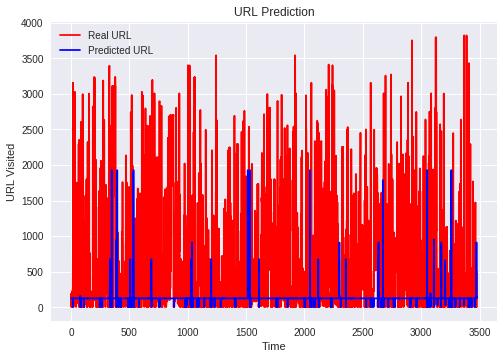

In [0]:
# Visualising the results
plt.plot(real_urls, color = 'red', label = 'Real URL')
plt.plot(predicted_url, color = 'blue', label = 'Predicted URL')
plt.title('URL Prediction')
plt.xlabel('Time')
plt.ylabel('URL Visited')
plt.legend()
plt.show()